Instalando e importando pacotes

In [ ]:
!pip install numpy matplotlib pydicom scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os

from pydicom import dcmread
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from scipy.ndimage import binary_dilation, binary_erosion
from pydicom.pixel_data_handlers.util import apply_modality_lut

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


Rota das imagens e nomes das pastas que contém os exames

In [ ]:
folders = ["3", "7", "8/CT-INSPIRIUM-8871", "8/CT-INSPIRIUM-8873", "12", "17", "19"]
root_path = "/content/gdrive/MyDrive/Faculdade/proc-img-biomedicas/scans/"

## Avaliando uma imagem individualmente

Visualizando a imagem

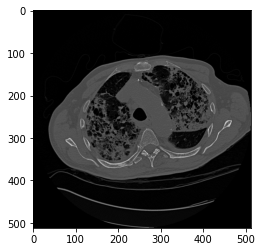

In [ ]:
img_path = root_path + '3/CT-7358-0010.dcm'
ds = dcmread(img_path) 


plt.imshow(ds.pixel_array, cmap="gray")

Transformando a imagem na escala Houndfield

In [ ]:
hu = apply_modality_lut(ds.pixel_array, ds)


Segundo a tabela da escala Hounsfield, a medida de HU para o pulmão se encontra entre -600 e -700. Vamos aplicar um filtro na imagem e manter apenas os pixels menores que -600 para tentar isolar o pulmão dos ossos e outros materiais.

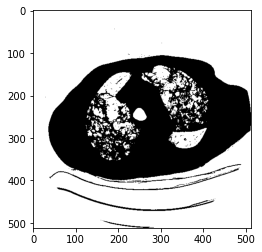

In [ ]:
mask = hu < -600

plt.imshow(mask, cmap="gray")
plt.show()

Os pixels brancos na parte central delimitam o pulmão. Vamos remover os pixels brancos externos (que não foram removidos pois o HU do ar é -1000).
Para isso, vamos utilizar a função `clear_border` do Scikit que remove as bordas de um objeto.

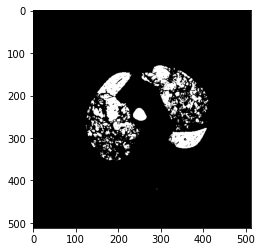

In [ ]:
mask = clear_border(mask)

plt.imshow(mask, cmap="gray")
plt.show()

Agora que temos apenas o pulmão em destaque, para deixá-lo com o formato mais consistente, vamos usar um método de dilatação. Inicialmente, vamos utilizar 20 iterações como parâmetro.

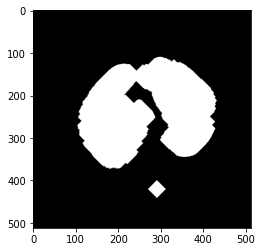

In [ ]:
dilated_img = binary_dilation(mask, iterations=20)

plt.imshow(dilated_img, cmap="gray")
plt.show()

Para voltarmos ao formato original, vamos aplicar a técnica de erosão.

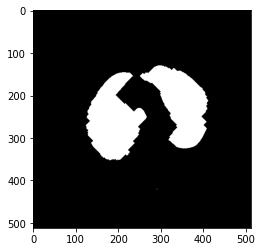

In [ ]:
eroded_img = binary_erosion(dilated_img,  iterations=20)

plt.imshow(eroded_img, cmap="gray")
plt.show()

Comparando com a máscara original

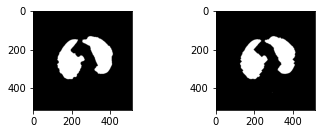

In [ ]:
mask_path = root_path + '3/lung_mask/lung_mask_7358_10.dcm'
ds_mask = dcmread(mask_path) 

plt.subplot(2, 2, 1)
plt.imshow(ds_mask.pixel_array, cmap="gray")

plt.subplot(2, 2, 2)
plt.imshow(eroded_img, cmap="gray")

## Aplicando em todas as imagens

Função que realiza a segmentação

In [ ]:
def generate_lung_mask(img, iterations: int):
  mask = img < -600
  mask = clear_border(mask)
  dilated_img = binary_dilation(mask, iterations=iterations)
  eroded_img = binary_erosion(dilated_img,  iterations=iterations)
  return eroded_img

Função que calcula as métricas

In [ ]:
def calculate_metrics(arr_mask, generated_mask) -> tuple:
  true_positive, false_positive, true_negative, false_negative = 0, 0, 0, 0
  for i, arr in enumerate(arr_mask):
    for j, val in enumerate(arr):
      
      if bool(val) == bool(generated_mask[i][j]):
        if val:
          true_positive += 1
        else:
          true_negative += 1
      else:
        if not val:
          false_positive += 1
        else:
          false_negative += 1

  return (true_positive, false_positive, true_negative, false_negative)

Função que realiza a segmentação e calcula as métricas para todas as imagens

In [ ]:
def calculate_metrics_for_all_images(iterations: int, visualize: bool = False) -> tuple:
  TP, FP, TN, FN = 0, 0, 0, 0
  num_imgs = 0
  DSC = 0

  for folder in folders:
    path = root_path + folder
    mask_path = root_path + folder + "/lung_mask"

    files = [f for f in os.listdir(path) if f.startswith("CT")]
    files.sort()

    for index, filename in enumerate(files):
      # Calcula o numero total de imagens
      num_imgs += 1

      # Informacoes do nome da imagem
      filename_split = filename.split("-")
      id = int(filename_split[1])
      number = int(filename_split[2].split(".")[0])
      # Informacoes do nome da mascara original da imagem
      mask_name = "lung_mask_{}_{}.dcm".format(id, number)

      # Abre a imagem
      ds = dcmread(path + "/" + filename) 
      arr = ds.pixel_array
      # Transforma em HU
      hu = apply_modality_lut(arr, ds)

      # Abre a mascara original
      ds_mask = dcmread(mask_path + "/" + mask_name) 
      arr_mask = ds_mask.pixel_array

      # Gera a mascara atraves da segmentacao aplicada
      generated_mask = generate_lung_mask(hu, iterations)

      # Calcula as metricas
      (true_positive, false_positive, true_negative, false_negative) = calculate_metrics(arr_mask, generated_mask)
      TP += true_positive
      FP += false_positive
      TN += true_negative
      FN += false_negative
      DSC += (2 * true_positive) / ((2 * true_positive) + false_positive + false_negative)

      # Mostra as imagens 
      if visualize:
        plt.subplot(3, 3, 1)
        plt.imshow(arr, cmap="gray")
        plt.gca().set_title('Original')

        plt.subplot(3, 3, 2)
        plt.imshow(arr_mask, cmap="gray")
        plt.gca().set_title('Mascara correta')
        
        plt.subplot(3, 3, 3)
        plt.imshow(generated_mask, cmap="gray")
        plt.gca().set_title('Mascara gerada')

        plt.show()

  precision = TP / (TP + FP)
  recall = TP / (TP + FN)
  f1_score = (2 * precision * recall) / (precision + recall)
  acc = (TP + TN) / (TP + FN + TN + FP)
  DSC = (DSC / num_imgs)

  return TP, FP, TN, FN, num_imgs, precision, recall, f1_score, acc, DSC


Para encontrar o melhor valor para o parâmetro de quantidade de iterações nas funções de erosão e dilatação, vamos comparar o coeficiente Dice para o intervalo de 1 a 50.

In [ ]:
x_values = [i for i in range(1, 20)]
y_values = []
best_value = (0, 0)
for x in x_values:
  TP, FP, TN, FN, num_imgs, precision, recall, f1_score, acc, DSC = calculate_metrics_for_all_images(x)
  y_values.append(DSC)
  if DSC > best_value[1]:
    best_value = (x, DSC)

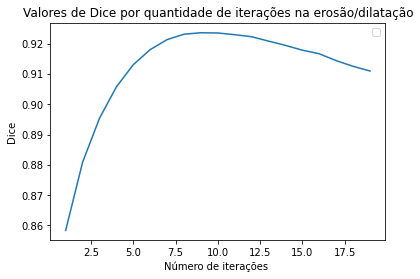

In [ ]:
plt.plot(x_values, y_values)
plt.xlabel('Número de iterações ')
plt.ylabel('Dice')
plt.title('Valores de Dice por quantidade de iterações na erosão/dilatação')
plt.legend()
plt.show()

In [ ]:
best_value

(9, 0.9236689334145401)

O melhor valor encontrado foi 9, que resulta nas métricas visualizadas abaixo. 

In [ ]:
TP, FP, TN, FN, num_imgs, precision, recall, f1_score, acc, DSC = calculate_metrics_for_all_images(9, False)

In [ ]:
TP, FP, TN, FN, num_imgs,
print("Num images: {}".format(num_imgs)) 
print("True Positive: {}".format(TP)) 
print("False Positive: {}".format(FP)) 
print("True Negative: {}".format(TN)) 
print("False Negative: {}".format(FN)) 

print("Precision: {}".format(precision)) 
print("Recall: {}".format(recall)) 
print("F1 Score: {}".format(f1_score)) 
print("Accuracy: {}".format(acc)) 
print("Dice: {}".format(DSC))

Num images: 178
True Positive: 5251949
False Positive: 182888
True Negative: 41168144
False Negative: 58651
Precision: 0.9663489447797606
Recall: 0.9889558618611833
F1 Score: 0.977521714565913
Accuracy: 0.9948236058267315
Dice: 0.9111447320402273
